In [1]:
# Package imports
import pandas as pd
import polars as pl
import numpy as np
import pickle
from sklearn.metrics import mean_squared_error, r2_score

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

from itertools import product

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler

# Plotting imports
import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline


In [2]:
def count_csv_rows(filepath):
    with open(filepath, 'rb') as f:  # Open in binary mode for speed
        return sum(1 for line in f)

csv_path = "C:/group_project_data.csv"
row_count = count_csv_rows(csv_path)
print(f"Number of rows: {row_count}")

Number of rows: 868971


In [3]:
# ----- Use the lazy API to load and transform data -----
# Use scan_csv to create a LazyFrame (does not immediately load all data into RAM)

lazy_df = pl.scan_csv("C:/group_project_data.csv")

# lazy_df = pl.scan_csv("C:/group_project_data.csv").limit(1000)


In [4]:
# Chain all transformations in lazy mode:
lazy_transformed = (
    lazy_df
    # Create the target variable from existing columns
    .with_columns((pl.col('HSEP001S') / pl.col('HSHNIAGG')).alias('target'))
    # Drop a column directly
    .drop("CODE")
)

# List of columns to drop (only keep those that exist in the schema)
columns_to_drop = [
    "HSHNIAGG", "HSAGDISPIN", "HSAGDISCIN", "HSTX001", "HSEP001S",
    "HSSH006", "HSSH015", "HSSH019", "HSSH044", "HSHC022", "HSHC025",
    "HSTR032", "ECYINDFINA", "ECYHRIHHD", "ECYHRI_020", "ECYHRI2040",
    "ECYHRI4060", "ECYHRI6080", "ECYHRIX100", "ECYHRI100P", "ECYHRIX125",
    "ECYHRIX150", "ECYHRIX200", "ECYHRI200P", "ECYHRIX300", "ECYHRI300P",
    "ECYHRIAVG", "ECYHRIMED", "ECYHRIAGG", "ECYHNIHHD", "ECYHNI_020",
    "ECYHNI2040", "ECYHNI4060", "ECYHNI6080", "ECYHNIX100", "ECYHNI100P",
    "ECYHNIX125", "ECYHNIX150", "ECYHNIX200", "ECYHNI200P", "ECYHNIX300",
    "ECYHNI300P", "ECYHNIAVG", "ECYHNIMED", "ECYHNIAGG", "ECYPNIHP15",
    "ECYPNININ", "ECYPNIWIN", "ECYPNIAVG"
]
# Filter out any columns not present in the data (using lazy frame's schema)
existing_cols = [col for col in columns_to_drop if col in lazy_transformed.columns]
lazy_transformed = lazy_transformed.drop(existing_cols)

# Remove rows with nulls or NaN in 'target'
lazy_transformed = (
    lazy_transformed
    .drop_nulls(subset=["target"])
    .filter(~pl.col("target").is_nan())
)

# Collect into eager DataFrame
merged_df = lazy_transformed.collect()

C:\Users\mrezae7\AppData\Local\Temp\ipykernel_3472\1915022296.py:24: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  existing_cols = [col for col in columns_to_drop if col in lazy_transformed.columns]


In [5]:
# If you have categorical variables – e.g., "GEO" – and you wish to one-hot encode:
# In case "GEO" always has a single unique value, this operation will result in a single dummy.
merged_df = merged_df.to_dummies(columns=['GEO'], drop_first=True)

# ----- Inspect and process the collected DataFrame -----
print(merged_df.head())
print(f"Shape after transformation: {merged_df.shape}")

shape: (5, 444)
┌──────────┬───────────┬────────────┬────────────┬───┬──────────────┬─────────────┬──────────────┬──────────┐
│ ECYASQKM ┆ ECYALSQKM ┆ ECYBASPOP  ┆ ECYBASTNGH ┆ … ┆ HSTR056A     ┆ HSTR056B    ┆ HSTR057      ┆ target   │
│ ---      ┆ ---       ┆ ---        ┆ ---        ┆   ┆ ---          ┆ ---         ┆ ---          ┆ ---      │
│ i64      ┆ i64       ┆ f64        ┆ f64        ┆   ┆ f64          ┆ f64         ┆ f64          ┆ f64      │
╞══════════╪═══════════╪════════════╪════════════╪═══╪══════════════╪═════════════╪══════════════╪══════════╡
│ 0        ┆ 0         ┆ 55.0       ┆ 0.0        ┆ … ┆ 1132.355623  ┆ 562.557865  ┆ 707.665394   ┆ 0.04     │
│ 0        ┆ 0         ┆ 571.197529 ┆ 38.0       ┆ … ┆ 8089.461528  ┆ 3995.11955  ┆ 9687.319907  ┆ 0.059753 │
│ 0        ┆ 0         ┆ 571.197529 ┆ 40.47709   ┆ … ┆ 16062.241477 ┆ 6783.786567 ┆ 13747.017489 ┆ 0.052055 │
│ 0        ┆ 0         ┆ 452.0      ┆ 35.0       ┆ … ┆ 5897.805493  ┆ 2931.427257 ┆ 7163.833309  ┆ 0.056

In [6]:
# ----- Train-test-val split -----
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(
    merged_df.drop('target'),
    merged_df.select('target'),
    test_size=0.1,
    random_state=0
)

Xtrain_main, Xval, ytrain_main, yval = train_test_split(
    Xtrain,
    ytrain,
    test_size=0.12,
    random_state=0
)

print("Training set shapes:", Xtrain_main.shape, ytrain_main.shape)
print("validation set shapes:", Xval.shape, yval.shape)
print("Testing set shapes:", Xtest.shape, ytest.shape)

Training set shapes: (614797, 443) (614797, 1)
validation set shapes: (83837, 443) (83837, 1)
Testing set shapes: (77627, 443) (77627, 1)


In [7]:
del merged_df

In [9]:
# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.001, 0.01, 0.1],
    'max_depth': [4, 6, 8],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Track best model
best_rmse = float('inf')
best_params = None
best_model = None

# Iterate over all combinations
for n_estimators, learning_rate, max_depth, subsample, colsample_bytree in product(
    param_grid['n_estimators'],
    param_grid['learning_rate'],
    param_grid['max_depth'],
    param_grid['subsample'],
    param_grid['colsample_bytree']
):
    model = XGBRegressor(
        objective='reg:squarederror',
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=42
    )

    model.fit(Xtrain_main, ytrain_main.to_numpy().ravel())
    preds = model.predict(Xval)
    rmse = mean_squared_error(yval, preds)

    print(f"Params: n_estimators={n_estimators}, lr={learning_rate}, depth={max_depth}, subsample={subsample}, colsample={colsample_bytree} -> RMSE={rmse:.8f}")

    if rmse < best_rmse:
        best_rmse = rmse
        best_params = {
            'n_estimators': n_estimators,
            'learning_rate': learning_rate,
            'max_depth': max_depth,
            'subsample': subsample,
            'colsample_bytree': colsample_bytree
        }
        best_model = model

print("\n✅ Best Hyperparameters:")
print(best_params)
print(f"Validation RMSE: {best_rmse:.8f}")


Params: n_estimators=100, lr=0.001, depth=4, subsample=0.8, colsample=0.8 -> RMSE=0.00023551
Params: n_estimators=100, lr=0.001, depth=4, subsample=0.8, colsample=1.0 -> RMSE=0.00023530
Params: n_estimators=100, lr=0.001, depth=4, subsample=1.0, colsample=0.8 -> RMSE=0.00023549
Params: n_estimators=100, lr=0.001, depth=4, subsample=1.0, colsample=1.0 -> RMSE=0.00023530
Params: n_estimators=100, lr=0.001, depth=6, subsample=0.8, colsample=0.8 -> RMSE=0.00023113
Params: n_estimators=100, lr=0.001, depth=6, subsample=0.8, colsample=1.0 -> RMSE=0.00023085
Params: n_estimators=100, lr=0.001, depth=6, subsample=1.0, colsample=0.8 -> RMSE=0.00023116
Params: n_estimators=100, lr=0.001, depth=6, subsample=1.0, colsample=1.0 -> RMSE=0.00023086
Params: n_estimators=100, lr=0.001, depth=8, subsample=0.8, colsample=0.8 -> RMSE=0.00022772
Params: n_estimators=100, lr=0.001, depth=8, subsample=0.8, colsample=1.0 -> RMSE=0.00022744
Params: n_estimators=100, lr=0.001, depth=8, subsample=1.0, colsample=

In [10]:
xgb_model = best_model

In [11]:
# ----- Saving the model -----
with open('xgb_model_best.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)

In [12]:
# ----- Loading the model -----
with open('xgb_model_best.pkl', 'rb') as f:
    xgb_model = pickle.load(f)

In [13]:
# ----- Testing and results -----
y_pred = xgb_model.predict(Xtest)
ytest = ytest.to_numpy()

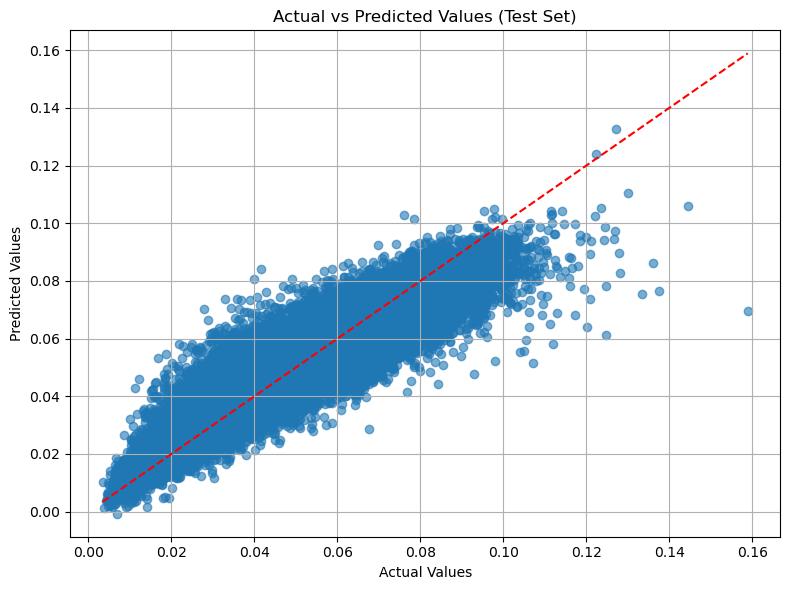

In [14]:
# Plot: Actual vs Predicted values (Test Set)
plt.figure(figsize=(8, 6))
plt.scatter(ytest, y_pred, alpha=0.6)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (Test Set)')
plt.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()], 'r--')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Metrics: Mean Squared Error and R² Score
mse = mean_squared_error(ytest, y_pred)
r2 = r2_score(ytest, y_pred)

In [34]:
print(f"Mean Squared Error (MSE): {mse:.8f}")
print(f"R² Score: {r2:.4f}")

Mean Squared Error (MSE): 0.00004948
R² Score: 0.8006


In [17]:
# Bootstrapping confidence intervals
n_bootstraps = 100
bootstrapped_MSE = np.zeros(n_bootstraps)
bootstrapped_r2 = np.zeros(n_bootstraps)

for i in range(n_bootstraps):
    idx = np.random.choice(len(ytest), len(ytest), replace=True)
    bootstrapped_MSE[i] = mean_squared_error(ytest[idx], y_pred[idx])
    bootstrapped_r2[i] = r2_score(ytest[idx], y_pred[idx])

mse_diff = bootstrapped_MSE - mse
r2_diff = bootstrapped_r2 - r2

mse_ci = np.percentile(mse_diff, [2.5, 97.5])
r2_ci = np.percentile(r2_diff, [2.5, 97.5])

print(f"The 95% confidence interval for the mse is [{(mse - mse_ci[1])*100:.4f}%, {(mse - mse_ci[0])*100:.4f}%]")
print(f"The 95% confidence interval for the r2 is [{(r2 - r2_ci[1]):.4f}, {(r2 - r2_ci[0]):.4f}]")


The 95% confidence interval for the mse is [0.0049%, 0.0050%]
The 95% confidence interval for the r2 is [0.7980, 0.8037]
